## Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었는가
:
분석 단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었는가
<br/>
<br/>

## 텍스트 요약모델이 성공적으로 학습되었음을 확인하였는가
:
모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다
<br/>
<br/>

## Extractive 요약을 시도해 보고 Abstractive 요약 결과와 함께 비교해 보았는가
:
두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다

In [30]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')



[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
data = pd.read_csv('news_summary_more.csv')
print('전체 샘플수 :', (len(data)))

print(data.head())

전체 샘플수 : 98401
                                           headlines  \
0  upGrad learner switches to career in ML & Al w...   
1  Delhi techie wins free food from Swiggy for on...   
2  New Zealand end Rohit Sharma-led India's 12-ma...   
3  Aegon life iTerm insurance plan helps customer...   
4  Have known Hirani for yrs, what if MeToo claim...   

                                                text  
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1  Kunal Shah's credit card bill payment platform...  
2  New Zealand defeated India by 8 wickets in the...  
3  With Aegon Life iTerm Insurance plan, customer...  
4  Speaking about the sexual harassment allegatio...  


In [32]:
print(data['headlines'][10])
print(data['text'][10])

data_sample = data.sample(10)

UP cousins fed human excreta for friendship with boys
Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.


10번째 데이터를 분석해본 결과, 굉장히 흥미로웠습니다

뉴스 헤드라인에 우정을 위해서 똥을 먹였다 라는 글이 써져있어서
이상치인가? 싶어서 text를 보게 되었는데,
똥을 먹인게 폭력이었으며 이를 가해자가 우정이라 치부한 것이었다는 사실을 알게 되었습니다

여기서 하나 배우게 된게,
뉴스 타이틀은 기본 문법은 지키면서 상식적이지 않고, 자극적인 소재로 쓰면 독자의 호기심을 자극할 수 있구나를 알게 되었습니다

In [33]:
print('headlines 유일한 샘플의 수 :', data['headlines'].nunique())
print('Text 유일한 샘플의 수 :', data['text'].nunique())

print(len(data))

headlines 유일한 샘플의 수 : 98280
Text 유일한 샘플의 수 : 98360
98401


headlines은 120개의 값이 중복이고,
text는 40개의 값이 중복입니다

일단 text는 긴 문장이기 때문에 중복이 생기기 어려울텐데 중복이 있으므로 text를 삭제합니다

그리고 headlines은 텍스트 내용이 완전히 일치하지 않고 비슷하더라도 똑같은 결과를 낼 수 있기 때문에 삭제하지 않습니다

즉 텍스트의 중복값만 삭제해 전체 데이터 중 80개는 text가 다르더라도 headlines이 같을 수 있다는 가능성을 살려줍니다

In [34]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', data['text'].nunique())

전체 샘플수 : 98360


In [35]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [36]:
def str_len(data):
    strlen = 0
    for i in data:
        if len(i) == 0:
            strlen +=1
            
    return strlen

print(data['headlines'].shape)
print(str_len(data['headlines']))

print(str_len(data['text']))


# 만든 함수 확인해보기
Doh = {'a':['scd', 'qdqw', 'asdca', 'qweqz', '']}
print(str_len(Doh['a']))

Doh = {'a':['scd', 'qdqw', 'asdca', 'qweqz', '', '']}
print(str_len(Doh['a']))

(98360,)
0
0
1
2


결측치는 없습니다

하지만 데이터를 전처리 하다보면 str 길이가 0이지만, 결측치가 아닌 데이터가 생길 수 있기 때문에,

len(str)이 0이면 결측치가 있다고 판단하는 함수를 만들었습니다

In [37]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

stopword = stopwords.words('english')

print('불용어 개수 :', len(stopword))

stop_contraction = []

for word in contractions:
    if word in stopword:
        stop_contraction.append(word)
        
print(stop_contraction)


정규화 사전의 수:  120
불용어 개수 : 179
["aren't", "couldn't", "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "isn't", "it's", "mightn't", "mustn't", "needn't", "shan't", "she's", "should've", "shouldn't", "wasn't", "weren't", "won't", "wouldn't", "you'd", "you'll", "you're", "you've"]


contraction와 stopword가 중복되는 값이 있습니다

만약 정규화를 하게 된다면, stopword에 감지되지 않게 됩니다

In [38]:
import copy

contractions_c = copy.deepcopy(contractions)

print(len(contractions))
print(len(contractions_c))

print(contractions == contractions_c)

120
120
True


In [39]:
contractions_c

for con in contractions.keys():
    if con in stop_contraction:
        del contractions_c[con]

In [40]:
print(len(contractions))
print(len(stop_contraction))
print(len(contractions_c))

120
25
95


해당 데이터를 삭제한 또다른 contractions_c를 만들어줍니다

허나 해당 데이터를 삭제한다고 무조건 성능이 향상될거란 보장이 없으므로,
추후 성능비교를 하고자 합니다

In [41]:
# 데이터 전처리 함수 origin
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens



In [42]:
# 데이터 전처리 함수 v1
def preprocess_sentence1(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions_c else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

# 새로 만든 contractions_c 적용

In [43]:
# 전처리 함수 확인하기

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

tdh = data['headlines'][10]
tdt = data['text'][10]


print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.
print("text: ", preprocess_sentence(tdt))
print("summary:", preprocess_sentence(tdh, False))  # 불용어를 제거하지 않습니다.


print("text: ", preprocess_sentence1(temp_text))
print("summary:", preprocess_sentence1(temp_summary, False))  # 불용어를 제거하지 않습니다.
print("text: ", preprocess_sentence1(tdt))
print("summary:", preprocess_sentence1(tdh, False))  # 불용어를 제거하지 않습니다.


print(preprocess_sentence(tdh) == preprocess_sentence1(tdh))
print(preprocess_sentence(tdt) == preprocess_sentence1(tdt))

for csdif in data['headlines']:
    if preprocess_sentence(csdif) == preprocess_sentence1(csdif):
        continue
    else:
        print(preprocess_sentence(csdif))
        print(preprocess_sentence1(csdif))
        


text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day
text:  two minor cousins uttar pradesh gorakhpur allegedly repeatedly burnt tongs forced eat human excreta family friends two boys school cousins revealed ordeal police child welfare committee brought back gorakhpur nepal fled escape torture
summary: up cousins fed human excreta for friendship with boys
text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day
text:  two minor cousins uttar pradesh gorakhpur allegedly repeatedly burnt tongs forced eat human excreta family friends two boys school cousins revealed ordeal police child welfare committee brought back gorakhpur nepal fled escape torture
summary: up cousins fed human excreta for friendship with boys
True
True
could say agneepath hrithik film completing yrs
say agneepath hrithik film completing yrs
bharat needs eid release could fit time abcd

새로 만든 contractions_c가 불용어를 더 확실하게 없앤 것을 확인할 수 있습니다

데이터를 headlines으로 한 이유는 text가 너무 길기 때문에,
셀의 크기가 커지는 것을 방지하기 위해 headlines으로 더미 실험을 했습니다

In [44]:
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence1(s))

print("Text 전처리 후 결과: ", clean_text[:5])


clean_summary = []
for s in data['headlines']:
    clean_summary.append(preprocess_sentence1(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [45]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [46]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

결측치가 없으니 다음 단계로 넘어가겠습니다

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09229361529077
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.27199064660431


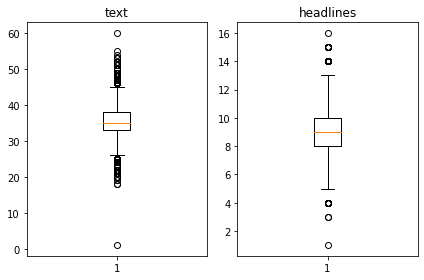

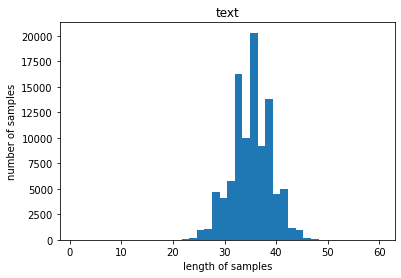

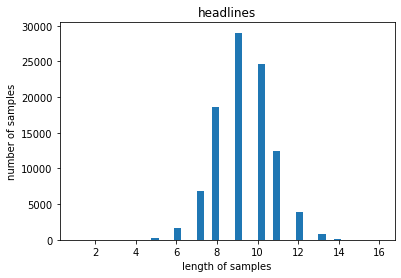

In [47]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [48]:
text_max_len = 45
summary_max_len = 12

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len, data['headlines'])


전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9968178121187474
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9904839365595771


In [49]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97114


In [50]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [51]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

print(encoder_input[0])

saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers


In [52]:
print(len(data['headlines']))
print(len(data['text']))
print(len(data['decoder_input']))
print(len(data['decoder_target']))

97114
97114
97114
97114


In [53]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)
# 랜덤 시드를 이런식으로 만들었구나
# 0.2는 훈련데이터와 테스트데이터의 비율이고

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[69015   619 15087 ... 73767 59250 18378]
테스트 데이터의 수 : 19422
훈련 데이터의 개수 : 77692
훈련 레이블의 개수 : 77692
테스트 데이터의 개수 : 19422
테스트 레이블의 개수 : 19422


print(src_tokenizer.word_counts.items())

위 코드를 실행하면 아래와 같은 결과가 나옵니다
![nn](word_counts.items.png)

print(src_tokenizer.word_counts)

위 코드를 실행하면 아래와 같은 결과가 나옵니다

위 코드와의 차이점이 컨테이너 이름 뿐인 거 같은데, 해당 차이가 어떤 역할을 하는지는 잘 모르겠습니다
![nn](word_counts.png)

print(src_tokenizer.word_index)

위 코드를 실행하면 아래와 같은 결과가 나옵니다
![nn](word_index.png)


encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [55]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


In [56]:
print(np.array(list(src_tokenizer.word_counts.items())).shape)

Frequency_src = dict(src_tokenizer.word_counts.items()).values()

print(max(list(Frequency_src)))
print(min(list(Frequency_src)))
#print(list(Frequency_src))


p0005 = 0
p001 = 0
p01 = 0
p1 = 0
p10 = 0
p20 = 0
p30 = 0
p40 = 0
p50 = 0
p60 = 0
p70 = 0
p80 = 0
p90 = 0
p100 = 0


for asqw in list(Frequency_src):
    if asqw <= 42662*0.00005:
        p0005 += 1
    if asqw <= 42662*0.0001:
        p001 += 1
    if asqw <= 42662*0.001:
        p01 += 1
    if asqw <= 42662*0.01:
        p1 += 1
    if asqw <= 42662*0.1:
        p10 += 1
    if asqw <= 42662*0.2:
        p20 += 1
    if asqw <= 42662*0.3:
        p30 += 1
    if asqw <= 42662*0.4:
        p40 += 1
    if asqw <= 42662*0.5:
        p50 += 1
    if asqw <= 42662*0.6:
        p60 += 1
    if asqw <= 42662*0.7:
        p70 += 1
    if asqw <= 42662*0.8:
        p80 += 1
    if asqw <= 42662*0.9:
        p90 += 1
    if asqw <= 42662:
        p100 += 1

print(p0005,p001,p01,p1,p10, p20, p30, p40, p50, p60, p70, p80, p90, p100)

# 최대값을 숫자로 한 이유는 연산시간을 줄이기 위해서 입니다

(69119, 2)
42532
1
34376 42927 61272 67897 69080 69109 69115 69118 69118 69118 69118 69118 69118 69119


1차원 데이터 분포 확인

이렇게 하는 게 맞나..?

In [57]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 69119
등장 빈도가 6번 이하인 희귀 단어의 수: 47119
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22000
단어 집합에서 희귀 단어의 비율: 68.17083580491617
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5154701389317147


In [58]:
print(total_cnt-rare_cnt)

22000


In [59]:
src_vocab = 22000

src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성


In [60]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [61]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30017
등장 빈도가 5번 이하인 희귀 단어의 수: 19641
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10376
단어 집합에서 희귀 단어의 비율: 65.4329213445714
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.719620468831141


In [62]:
print(np.array(list(tar_tokenizer.word_counts.items())).shape)

Frequency_src = dict(tar_tokenizer.word_counts.items()).values()

print(max(list(Frequency_src)))
print(min(list(Frequency_src)))
#print(list(Frequency_src))


p0005 = 0
p001 = 0
p01 = 0
p1 = 0
p10 = 0
p20 = 0
p30 = 0
p40 = 0
p50 = 0
p60 = 0
p70 = 0
p80 = 0
p90 = 0
p100 = 0


for asqw in list(Frequency_src):
    if asqw <= 77692*0.00005:
        p0005 += 1
    if asqw <= 77692*0.0001:
        p001 += 1
    if asqw <= 77692*0.001:
        p01 += 1
    if asqw <= 77692*0.01:
        p1 += 1
    if asqw <= 77692*0.1:
        p10 += 1
    if asqw <= 77692*0.2:
        p20 += 1
    if asqw <= 77692*0.3:
        p30 += 1
    if asqw <= 77692*0.4:
        p40 += 1
    if asqw <= 77692*0.5:
        p50 += 1
    if asqw <= 77692*0.6:
        p60 += 1
    if asqw <= 77692*0.7:
        p70 += 1
    if asqw <= 77692*0.8:
        p80 += 1
    if asqw <= 77692*0.9:
        p90 += 1
    if asqw <= 77692:
        p100 += 1

print(int(77692*0.00005),p0005,int(77692*0.0001),p001,int(77692*0.001),p01,int(77692*0.01),p1,int(77692*0.1),p10,int(77692*0.20),p20,int(77692*0.3),p30,int(77692*0.4),p40,int(77692*0.5),p50,int(77692*0.6),p60,int(77692*0.7),p70,int(77692*0.8),p80,int(77692*0.9),p90,77692,p100)

# 최대값을 숫자로 한 이유는 연산시간을 줄이기 위해서 입니다

(30017, 2)
77692
1
3 16948 7 21291 77 28466 776 29925 7769 30011 15538 30014 23307 30015 31076 30016 38846 30016 46615 30016 54384 30016 62153 30016 69922 30016 77692 30017


In [63]:
print(total_cnt-rare_cnt)

10376


In [64]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input ',decoder_input_train[:5])
print('decoder ',decoder_target_train[:5])

input
input  [[1, 922, 502, 4, 3, 3, 567], [1, 915, 392, 4, 1773, 12, 4, 83], [1, 532, 10, 1853, 23, 7, 942, 222], [1, 18, 7, 1553, 3, 356, 37, 4, 62, 89], [1, 13, 153, 90, 471, 19, 45, 561, 3, 549]]
target
decoder  [[922, 502, 4, 3, 3, 567, 2], [915, 392, 4, 1773, 12, 4, 83, 2], [532, 10, 1853, 23, 7, 942, 222, 2], [18, 7, 1553, 3, 356, 37, 4, 62, 89, 2], [13, 153, 90, 471, 19, 45, 561, 3, 549, 2]]


In [71]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77682
훈련 레이블의 개수 : 77682
테스트 데이터의 개수 : 19419
테스트 레이블의 개수 : 19419


In [72]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)
# 입력된 데이터로부터 단어 집합 생성

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])
print(decoder_input_train[:3])
print(decoder_target_train[:3])
print(encoder_input_test[:3])
print(decoder_input_test[:3])
print(decoder_target_test[:3])

[[151, 26, 1283, 804, 68, 854, 1163, 676, 7307, 6415, 17, 1175, 5472, 73, 891, 12437, 6, 255, 854, 761, 445, 290, 1961, 14681, 60, 3, 13, 407, 616, 1146, 2961, 120, 200, 6415], [9, 2112, 73, 2005, 77, 109, 1038, 295, 6119, 2382, 9982, 1039, 5205, 978, 3264, 23814, 1031, 343, 216, 6119, 1861, 1602, 448, 8760, 9, 1, 23814, 1231, 2005, 7004, 672], [4882, 36, 57, 7093, 465, 11465, 8607, 56, 91, 1558, 57, 635, 399, 469, 7094, 47, 4841, 5828, 1472, 1830, 8, 2136, 229, 8607, 1, 2103, 5828, 1486, 1, 50, 113, 46, 9223, 2136, 2064, 2996, 229, 932]]
[[1, 922, 502, 4, 3, 3, 567], [1, 915, 392, 4, 1773, 12, 4, 83], [1, 532, 10, 1853, 23, 7, 942, 222]]
[[922, 502, 4, 3, 3, 567, 2], [915, 392, 4, 1773, 12, 4, 83, 2], [532, 10, 1853, 23, 7, 942, 222, 2]]
[[1972, 2704, 3014, 3067, 2361, 480, 17297, 3642, 271, 2178, 150, 3678, 795, 59, 3747, 24, 795, 150, 480, 28149, 3067, 7632, 1992, 206, 6078, 9780, 1, 372, 271, 193, 174, 291, 1031, 116, 44, 7, 188], [1693, 635, 399, 1865, 1395, 399, 1865, 6675, 6726,

In [73]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='pre')



In [74]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [75]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [76]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [77]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [78]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
304/304 [==============================] - 243s 760ms/step - loss: 3.8181 - val_loss: 3.6112
Epoch 2/50
304/304 [==============================] - 231s 759ms/step - loss: 3.5521 - val_loss: 3.4735
Epoch 3/50
304/304 [==============================] - 230s 758ms/step - loss: 3.4405 - val_loss: 3.3610
Epoch 4/50
304/304 [==============================] - 231s 759ms/step - loss: 3.3281 - val_loss: 3.3522
Epoch 5/50
304/304 [==============================] - 226s 745ms/step - loss: 3.2371 - val_loss: 3.1933
Epoch 6/50
304/304 [==============================] - 187s 615ms/step - loss: 3.1678 - val_loss: 3.1399
Epoch 7/50
304/304 [==============================] - 187s 617ms/step - loss: 3.1124 - val_loss: 3.1008
Epoch 8/50
304/304 [==============================] - 187s 617ms/step - loss: 3.0688 - val_loss: 3.0701
Epoch 9/50
304/304 [==============================] - 187s 616ms/step - loss: 3.0221 - val_loss: 3.0089
Epoch 10/50
304/304 [==============================] - 187s 616m

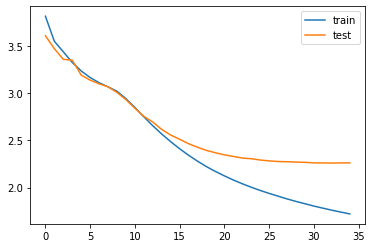

In [79]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [80]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [81]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [82]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [83]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


In [84]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


In [85]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")


원문 : us canada european union states monday expelled many russian diplomats russia alleged involvement poisoning former spy sergei skripal uk russia vowed retaliate expulsions diplomats calling move provocative gesture earlier russia uk expelled diplomats 
실제 요약 : countries russian in one day 
예측 요약 :  us russia to end russia in russia to spy on spy


원문 : cbi arrested two former sbi managers former canara bank manager four others allegedly defrauding sbi branch kolkata crore directors kolkata based private firm allegedly conspired bank officials discounted three bills using forged letters credit issued three banks 
실제 요약 : cbi arrests sbi officials others in cr fraud case 
예측 요약 :  ex bank manager arrested for fraud of fraud of ex bank


원문 : congress president rahul gandhi said keeping dalits bottom bjp dna union minister ram vilas paswan said moral right talk dalit issues added congress nothing dalit community abused leader br ambedkar comes amidst dalit protests supreme court rulin

!pip list | grep summa

클라우드가 아닐 경우 해당 코드를 실행해준다

In [86]:
import requests
from summa.summarizer import summarize

In [103]:
input_text = pd.read_csv('news_summary_more.csv')['text']

for _ in range(10):
    rnum = np.random.randint(len(input_text))
    print(f'원문:\n{input_text[rnum]}\n')
    print(f'요약문:\n{summarize(input_text[rnum], ratio=0.5)}')
    print('--'*50+'\n')

원문:
US-based researchers have found waves on lakes of Saturn's largest moon Titan reach only about 1 cm high. The calm lakes are an indication that winds are low, suggesting smooth landing for future probes sent there, scientists said. Previous studies using NASA's Cassini probe show Titan may possess life ingredients, making the moon an interesting place to explore, they added.

요약문:
US-based researchers have found waves on lakes of Saturn's largest moon Titan reach only about 1 cm high.
----------------------------------------------------------------------------------------------------

원문:
The US no longer seeks to oust Syrian President Bashar al-Assad but rather aims to achieve a "regime that is fundamentally different", the US Special Representative for Syria Engagement, Ambassador James Jeffrey said. He added that the West would not provide reconstruction aid to the war-torn country unless there is a compromise on the part of the Syrian government.

요약문:
The US no longer seeks to

ratio를 0.5로 지정해야 그나마 요약문이 없는 현상이 적어지는 것 같습니다

# 회고

처음으로 모델이 학습하는 시간을 보고 경악했습니다
early stopping을 쓴다 하더라도, 너무 오래 걸립니다

앞으로는 이것보다 더 오래걸린다고 하는데 앞으로 모델 튜닝을 한다면 어떻게 해야될지 막막하네요

## 좀 더 공부할 거

이번에는 1차원 데이터를 노가다 방식으로 시각화 했지만, 모든 1차원 데이터를 이번처럼 노가다 방식으로 시각화할 순 없다는 생각이 들었습니다
때문에 1차원 데이터를 어떻게 간단하게 시각화 하는지 알아봐야 될 거 같습니다

## 다음 목표

이번 노드를 하며 모델을 만드는 건 너무나도 중요하기 때문에 앞으로 제가 직접 하는거 보다는,
만들어진 것들을 쓸 경우의 수가 좀 더 많겠다 라는 생각이 들었습니다

왜냐하면 앞으로 더 많고 더 복잡한 데이터를 쓸텐데 그럼 학습시간도 비약적으로 늘어날 건데 모델을 잘못 만들면 그 학습을 위한 컴퓨팅 파워와 시간이 무의미하게 됩니다

### 그럼 뭘 하겠다는 건가?

데이터 전처리입니다
데이터 전처리는 인공지능 학습보다 비교적 시간이 덜 소모되며,
인공지능을 만들 때 무조건 해야되는 단계입니다

그리고 저 혼자 만드는 모델에는 한계가 있으며 이미 다른 사람들이 만든 훌륭한 모델이 많습니다

요약하자면, 모델을 만드는 전문적인 작업보다는 그 전문작업을 위한 기반을 만드는 작업을 남들보다 좀 더 잘하는 게 목표입니다